# 2016/17 Semester 1
# BM0249 Investment Analysis and Portfolio Management
# ICA 2
NB: Implementation in Python

# Learning Outcomes:
The expected learning outcome of this project is that the student will be able to:
1. Compute holding period returns, average returns, expected returns, and standard deviations.
2. Construct portfolios of different risk levels, and calculate its expected return and standard deviation.
3. Construct portfolios of varying degrees of risk using risk free and risky securities.
4. Calculate or estimate a firm's beta, and determine the firm's reaction to macroeconomic (market) events.
5. Demonstrate with a diversified portfolio the importance of beta as the sole measure of portfolio risk.

**Step 1**: Importing libraries to perform necessary data analysis

In [1]:
import pandas as pd
pd.set_option('precision', 4)
from scipy import stats
from scipy.stats import norm
import seaborn as sns
sns.set()
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm

Reading data into Python Pandas DataFrame

In [2]:
df = pd.read_excel("IAPM 2016S2.xlsx", skiprows=1,
                  names=['SPY', 'Tbill', 'XLU', 'VTI', 'AGG', 'QQQ', 'BND', 'XLP', 'BSV',
                         'EEM', 'BIV', 'EFA', 'VNQ', 'EWJ'], index_col='Date')

In [3]:
df.head(3)

,SPY,Tbill,XLU,VTI,AGG,QQQ,BND,XLP,BSV,EEM,BIV,EFA,VNQ,EWJ
Date,,,,,,,,,,,,,,
2010-01-29,107.39,0.06,29.53,54.36,104.65,42.79,79.60,26.20,80.34,38.2800,80.7000,52.48,42.27,39.36
2010-02-26,110.74,0.11,29.14,56.23,104.53,44.76,79.61,27.03,80.40,38.9600,80.7619,52.62,44.63,39.76
2010-03-31,117.00,0.15,29.66,59.59,104.20,48.16,79.20,27.93,80.00,42.1225,80.2800,55.98,48.81,41.76


# Background Info:
* SPY: SPDR S&P500 ETF Trust
* H15T3M: 3-Month Treasury Bill
* XLU: Utilities Select Sector SPDR Fund
* VTI: Vanguard Total Stock Market ETF
* AGG: US iShares Core U.S. Aggregate Bond ETF
* QQQ: US Powershares QQQ Trust Series 1
* BND: US Vanguard Total Bond Market ETF
* XLP: Consumer Staples Selct Sector SPDR Fund
* BSV: Vanguard Short-Term Bond ETF
* EEM: iShares MSCI Emerging Markets ETF
* BIV: Vanguard Intermediate-Term Bond ETF
* EFA: iShares MSCI EAFE ETF ([Europe, Australasia and Far East. Developed mkt outside of US and Canada](https://en.wikipedia.org/wiki/MSCI_EAFE))
* VNQ: Vanguard REIT ETF
* EWJ: iShares MSCI Japan ETF

We need to extract T-bill from the `Pandas DataFrame` and calculate the monthly T-bill / risk-free rate of returns differently as by convention the 3-Month T-bill data is provided in the form of yield whereas stock prices / ETF prices are provided in the form of raw price.

## Holding Period for T-bills:
Calculation of holding period return for T-bills can be calculate using the following:
$$HPR = \frac{Y}{n}$$
* $Y$ is the annualised yield
* $n$ is the number of period. E.g., To calculate daily yield, n is 365. To calculate monthly yield, n is 12.

In [4]:
risk_free = df['Tbill'] / 12 / 100# Convert the annual yield to monthly
del df['Tbill']

In [5]:
risk_free.head(3)

Date
2010-01-29    5.0000e-05
2010-02-26    9.1667e-05
2010-03-31    1.2500e-04
Name: Tbill, dtype: float64

In [6]:
df.head(3)

,SPY,XLU,VTI,AGG,QQQ,BND,XLP,BSV,EEM,BIV,EFA,VNQ,EWJ
Date,,,,,,,,,,,,,
2010-01-29,107.39,29.53,54.36,104.65,42.79,79.60,26.20,80.34,38.2800,80.7000,52.48,42.27,39.36
2010-02-26,110.74,29.14,56.23,104.53,44.76,79.61,27.03,80.40,38.9600,80.7619,52.62,44.63,39.76
2010-03-31,117.00,29.66,59.59,104.20,48.16,79.20,27.93,80.00,42.1225,80.2800,55.98,48.81,41.76


## Holding Period for Stocks:
Calculation of holding period return for stocks can be done using the following formula:
$$HPR = \frac{P_t - P_0 + CF}{P_0}$$
* $P_0$ is the beginning price
* $P_t$ is the ending price
* $CF$ is the cashflow received during the holding period

In [7]:
df_rtn = df.pct_change().dropna()
df_rtn.head(3)

,SPY,XLU,VTI,AGG,QQQ,BND,XLP,BSV,EEM,BIV,EFA,VNQ,EWJ
Date,,,,,,,,,,,,,
2010-02-26,0.0312,-0.0132,0.0344,-0.0011,0.0460,0.0001,0.0317,0.0007,0.0178,0.0008,0.0027,0.0558,0.0102
2010-03-31,0.0565,0.0178,0.0598,-0.0032,0.0760,-0.0052,0.0333,-0.0050,0.0812,-0.0060,0.0639,0.0937,0.0503
2010-04-30,0.0155,0.0263,0.0218,0.0066,0.0224,0.0076,-0.0107,0.0025,-0.0017,0.0108,-0.0280,0.0715,-0.0048


In [8]:
df_rtn = pd.merge(df_rtn, risk_free.to_frame(), left_index=True, right_index=True) # Add T-bill back

# Part 2.1: Security Analysis
## Part 2.1 (a)
This part is asking us to calculate the statistical analysis over the all the data. The data provided are in monthly raw price. So we calculate the monthly returns rather than daily.

Perform statistical analysis on TWO (2) ETFs, S&P 500 Index and risk-free assets daily returns over the past 5 years. Using the individual security’s daily return, compute the following:
1. Maximum daily returns
2. Minimum daily returns
3. Average daily returns
4. Median daily returns
5. Standard deviation & Variance of daily returns
6. Skewness
7. Kurtosis

In [9]:
raw = {'Max': df_rtn.max(), 
       'Min': df_rtn.min(), 
       'Average': df_rtn.mean(),
       'Median': df_rtn.median(), 
       'Standard_Deviation': df_rtn.std(), 
       'Variance': df_rtn.var(), 
       'Skewness': df_rtn.skew(), 
       'Kurtosis': df_rtn.kurt(),
      }
summary_stats = pd.DataFrame(data=raw)
summary_stats = summary_stats[['Max', 'Min', 'Average', 'Median', 
                               'Standard_Deviation', 'Variance', 'Skewness', 'Kurtosis']]
pd.set_option('display.float_format', lambda x: '%.4f' % x)
summary_stats

,Max,Min,Average,Median,Standard_Deviation,Variance,Skewness,Kurtosis
SPY,0.1091,-0.0795,0.0098,0.0129,0.0378,0.0014,-0.1186,0.1473
XLU,0.0803,-0.0905,0.0060,0.0108,0.0341,0.0012,-0.5181,0.4053
VTI,0.1137,-0.0806,0.0100,0.0130,0.0392,0.0015,-0.1406,0.1591
AGG,0.0205,-0.0218,0.0005,-0.0009,0.0084,0.0001,-0.0927,-0.2481
QQQ,0.1291,-0.0739,0.0146,0.0192,0.0439,0.0019,0.1255,-0.1048
BND,0.0240,-0.0211,0.0002,0.0001,0.0087,0.0001,-0.1266,0.2173
XLP,0.0639,-0.0596,0.0098,0.0103,0.0310,0.0010,-0.1937,-0.8522
BSV,0.0095,-0.0129,-0.0001,0.0004,0.0041,0.0000,-0.2778,0.3179
EEM,0.1630,-0.1791,-0.0008,-0.0030,0.0572,0.0033,0.0174,1.0847
BIV,0.0308,-0.0366,0.0005,0.0009,0.0134,0.0002,-0.4169,0.2885


## Part 2.1 (b)
Compute and plot return frequency distribution (vs Normal distribution) of the selected ETFs, S&P 500 Index and risk-free assets daily’s returns.

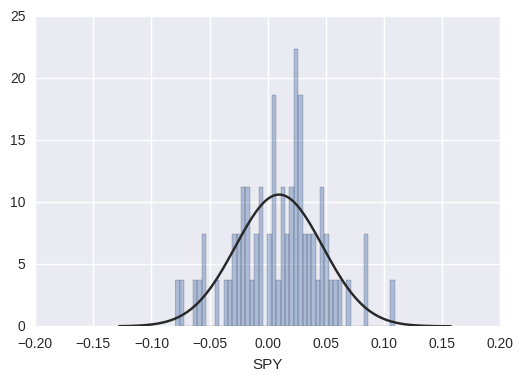

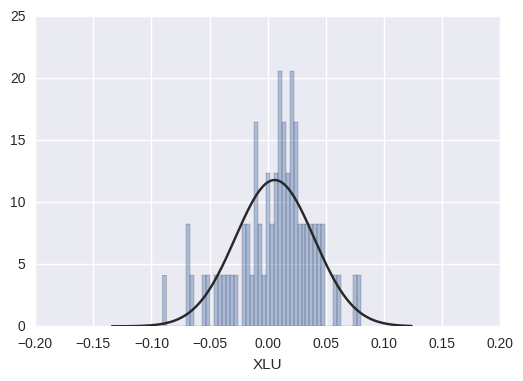

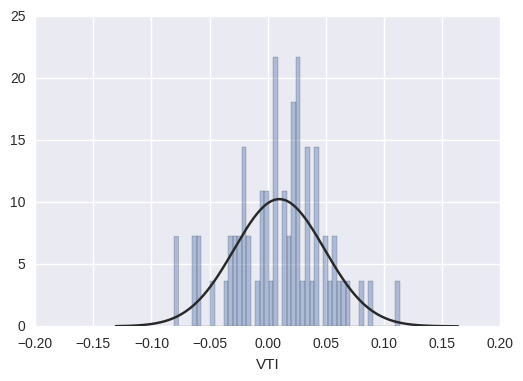

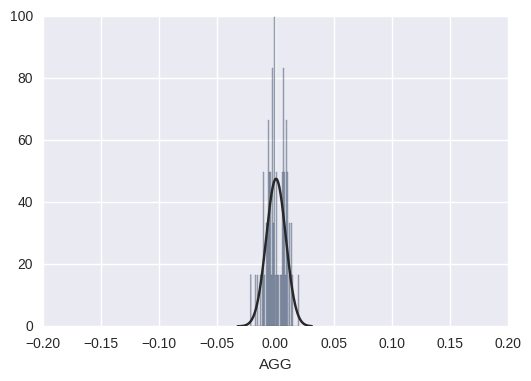

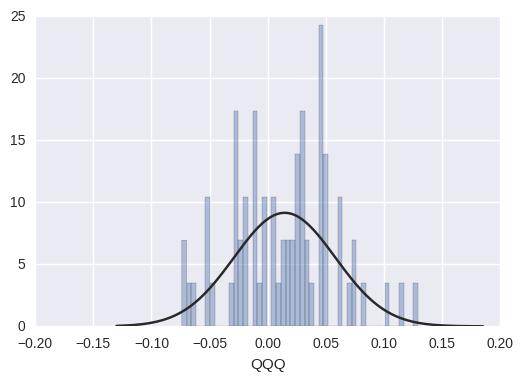

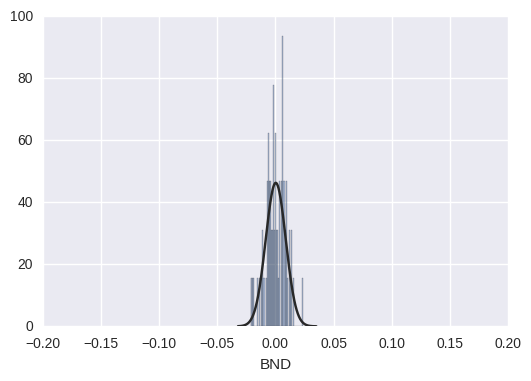

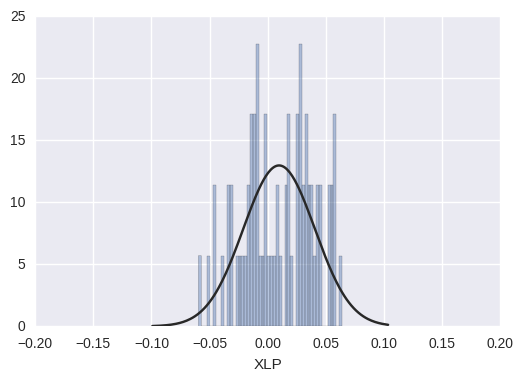

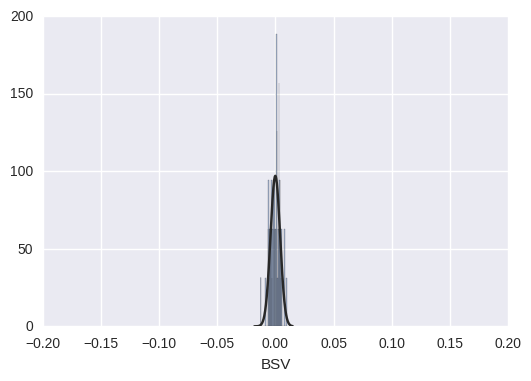

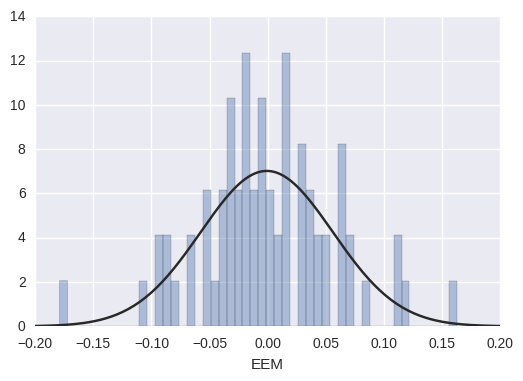

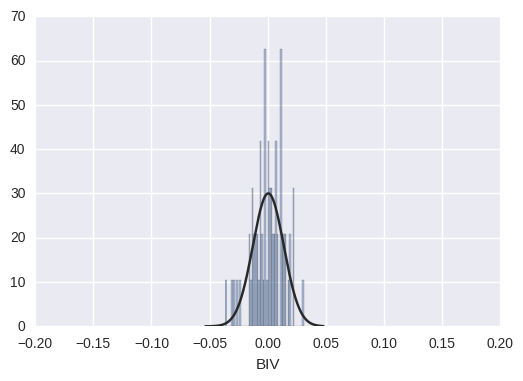

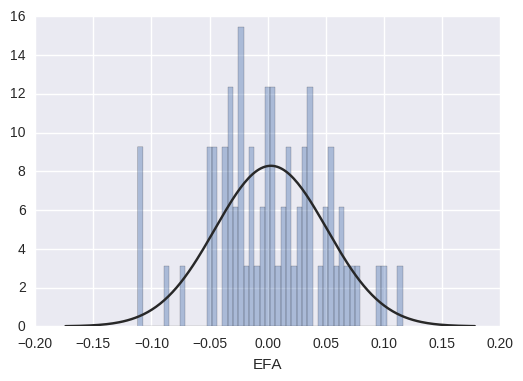

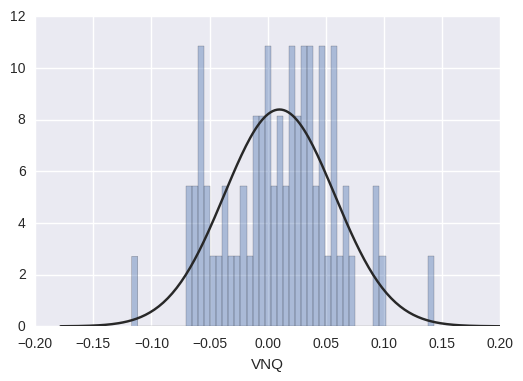

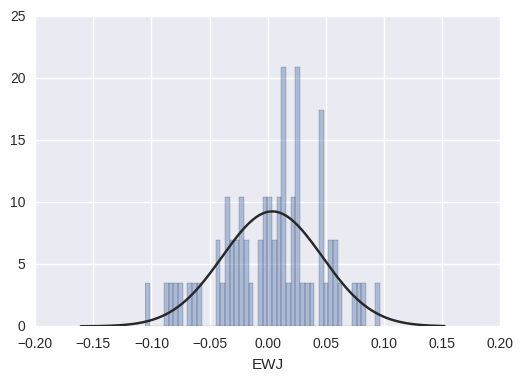

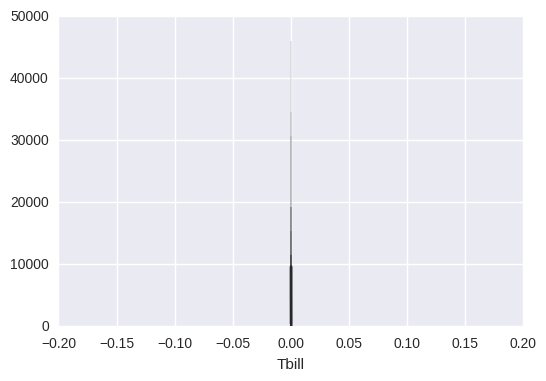

In [10]:
for oo in df_rtn.columns:
    plt.figure()
    plt.xlim(np.round(summary_stats['Min'].min(),1), np.round(summary_stats['Max'].max(),1))
    sns.distplot(df_rtn[oo], bins=50, fit=norm, kde=False);

## Part 2.1 (c)
Calculate the correlation coefficient of your allotted securities, S&P 500 Index and risk-free assets daily returns.

NB: We are performing this on returns and not on excess returns

### Correlation in a table format

In [11]:
corr_mat = df_rtn.corr()
corr_mat

,SPY,XLU,VTI,AGG,QQQ,BND,XLP,BSV,EEM,BIV,EFA,VNQ,EWJ,Tbill
SPY,1.0000,0.3276,0.9963,-0.1972,0.9356,-0.2193,0.7690,-0.0861,0.7850,-0.1687,0.8864,0.6482,0.6245,0.0415
XLU,0.3276,1.0000,0.3199,0.4449,0.1989,0.4287,0.5855,0.2986,0.1952,0.3787,0.3231,0.6206,0.1768,0.0259
VTI,0.9963,0.3199,1.0000,-0.2046,0.9291,-0.2242,0.7451,-0.0869,0.7926,-0.1743,0.8828,0.6567,0.6250,0.0545
AGG,-0.1972,0.4449,-0.2046,1.0000,-0.1241,0.9827,0.0831,0.8164,-0.0573,0.9575,-0.0756,0.3205,-0.1499,-0.0888
QQQ,0.9356,0.1989,0.9291,-0.1241,1.0000,-0.1363,0.6739,0.0003,0.7234,-0.0792,0.8317,0.5911,0.6194,0.0047
BND,-0.2193,0.4287,-0.2242,0.9827,-0.1363,1.0000,0.0577,0.8556,-0.0734,0.9719,-0.0934,0.3085,-0.1707,-0.0595
XLP,0.7690,0.5855,0.7451,0.0831,0.6739,0.0577,1.0000,0.0726,0.5057,0.0681,0.6686,0.5707,0.4312,0.0279
BSV,-0.0861,0.2986,-0.0869,0.8164,0.0003,0.8556,0.0726,1.0000,0.0715,0.8987,0.0601,0.2935,-0.0853,-0.0699
EEM,0.7850,0.1952,0.7926,-0.0573,0.7234,-0.0734,0.5057,0.0715,1.0000,-0.0150,0.8583,0.5782,0.5617,0.0920
BIV,-0.1687,0.3787,-0.1743,0.9575,-0.0792,0.9719,0.0681,0.8987,-0.0150,1.0000,-0.0463,0.3030,-0.1460,-0.0356


### Correlation in a heatmap format

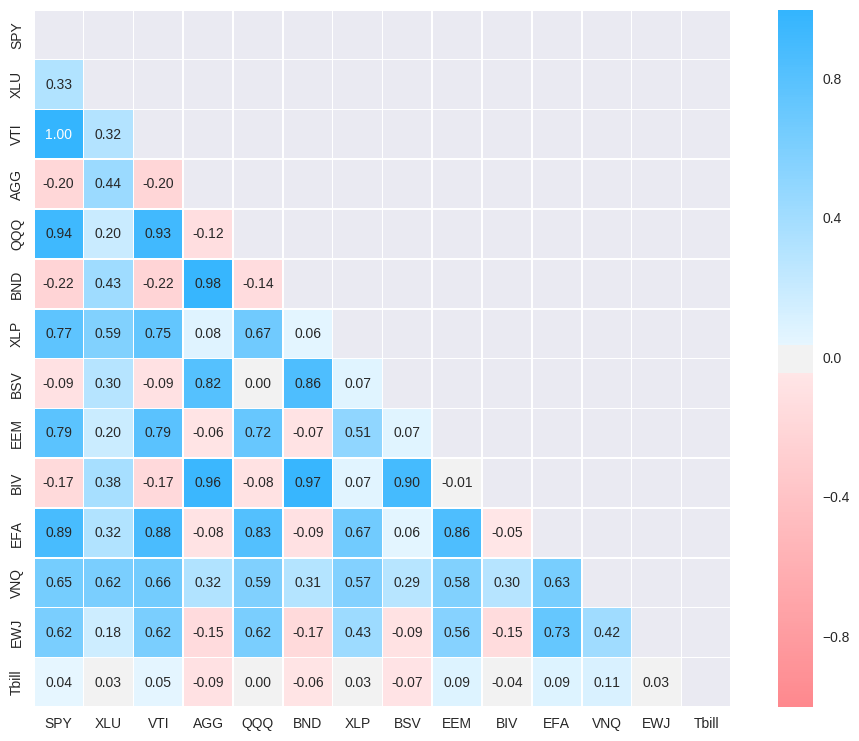

In [12]:
mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(12, 9))
#cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
cmap = sns.diverging_palette(10, 240, s=99, l=70, n=9, as_cmap=True)
with sns.axes_style("white"):
    ax = sns.heatmap(corr_mat, mask=mask, 
                     annot=True, fmt='.2f', vmin=-1, vmax=1, 
                     linewidths=.5, square=True,
                     cmap=cmap)

Isolate and display pairs of correlation coefficients < 0

In [13]:
a = corr_mat[corr_mat < 0].copy()
a.fillna('', inplace=True)
a

,SPY,XLU,VTI,AGG,QQQ,BND,XLP,BSV,EEM,BIV,EFA,VNQ,EWJ,Tbill
SPY,,,,-0.1972,,-0.2193,,-0.0861,,-0.1687,,,,
XLU,,,,,,,,,,,,,,
VTI,,,,-0.2046,,-0.2242,,-0.0869,,-0.1743,,,,
AGG,-0.1972,,-0.2046,,-0.1241,,,,-0.0573,,-0.0756,,-0.1499,-0.0888
QQQ,,,,-0.1241,,-0.1363,,,,-0.0792,,,,
BND,-0.2193,,-0.2242,,-0.1363,,,,-0.0734,,-0.0934,,-0.1707,-0.0595
XLP,,,,,,,,,,,,,,
BSV,-0.0861,,-0.0869,,,,,,,,,,-0.0853,-0.0699
EEM,,,,-0.0573,,-0.0734,,,,-0.0150,,,,
BIV,-0.1687,,-0.1743,,-0.0792,,,,-0.0150,,-0.0463,,-0.1460,-0.0356


## Part 2.1 (d)
Calculate the individual ETF’s beta (See Appendix B: Figure 4 & 5). Do not use an external source like Bloomberg to perform this task. Calculate your own beta.

NB: By convention, to perform this analysis excess returns are used

In [14]:
excess_rtn = df_rtn.sub(df_rtn['Tbill'], axis=0)
del excess_rtn['Tbill']
excess_rtn.head(3)

,SPY,XLU,VTI,AGG,QQQ,BND,XLP,BSV,EEM,BIV,EFA,VNQ,EWJ
Date,,,,,,,,,,,,,
2010-02-26,0.0311,-0.0133,0.0343,-0.0012,0.0459,0.0000,0.0316,0.0007,0.0177,0.0007,0.0026,0.0557,0.0101
2010-03-31,0.0564,0.0177,0.0596,-0.0033,0.0758,-0.0053,0.0332,-0.0051,0.0810,-0.0061,0.0637,0.0935,0.0502
2010-04-30,0.0154,0.0262,0.0217,0.0065,0.0222,0.0074,-0.0109,0.0024,-0.0019,0.0107,-0.0282,0.0714,-0.0049


### Group 1:

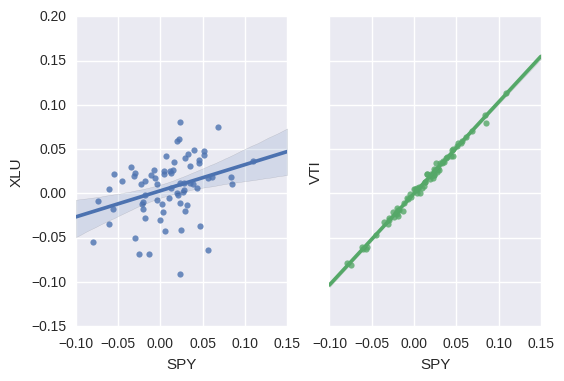

In [15]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
sns.regplot(excess_rtn['SPY'], excess_rtn['XLU'], ax=ax1);
sns.regplot(excess_rtn['SPY'], excess_rtn['VTI'], ax=ax2);

### Group 2:

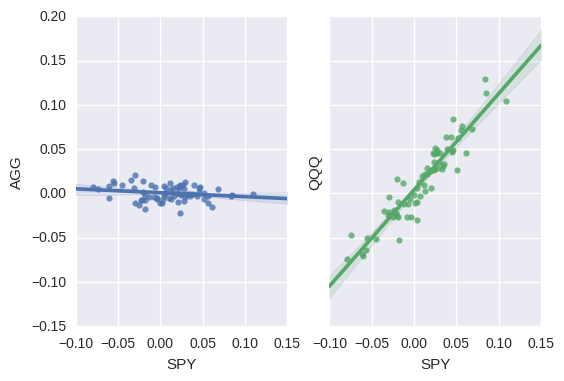

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
sns.regplot(excess_rtn['SPY'], excess_rtn['AGG'], ax=ax1);
sns.regplot(excess_rtn['SPY'], excess_rtn['QQQ'], ax=ax2);

### Group 3:

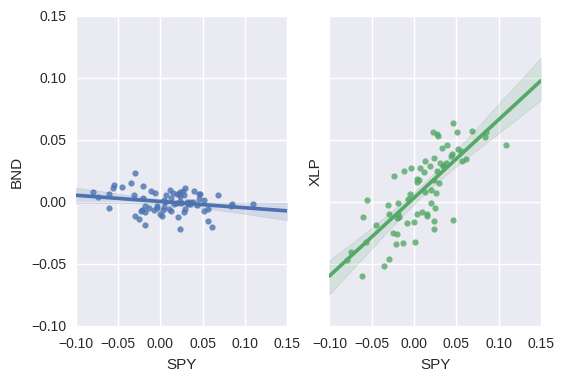

In [17]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
sns.regplot(excess_rtn['SPY'], excess_rtn['BND'], ax=ax1);
sns.regplot(excess_rtn['SPY'], excess_rtn['XLP'], ax=ax2);

### Group 4:

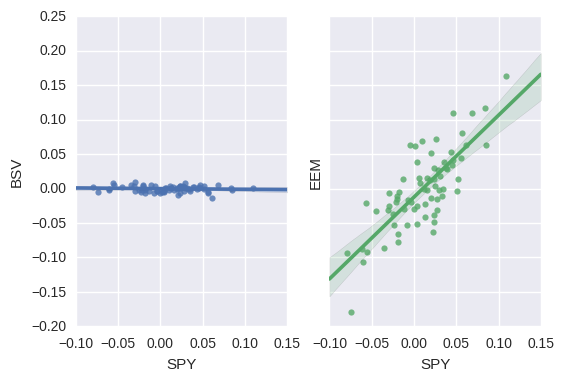

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
sns.regplot(excess_rtn['SPY'], excess_rtn['BSV'], ax=ax1);
sns.regplot(excess_rtn['SPY'], excess_rtn['EEM'], ax=ax2);

### Group 5:

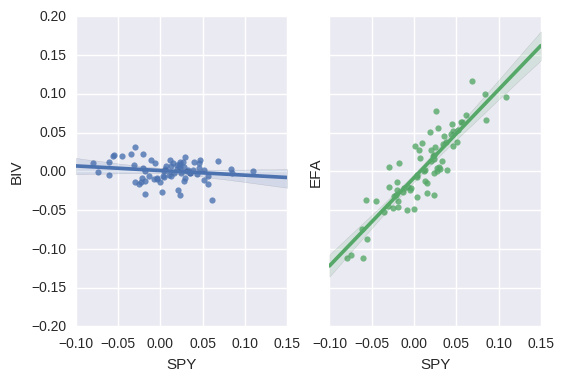

In [19]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
sns.regplot(excess_rtn['SPY'], excess_rtn['BIV'], ax=ax1);
sns.regplot(excess_rtn['SPY'], excess_rtn['EFA'], ax=ax2);

### Group 6:

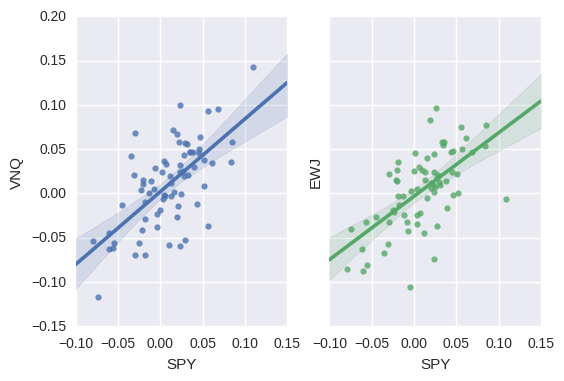

In [20]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
sns.regplot(excess_rtn['SPY'], excess_rtn['VNQ'], ax=ax1);
sns.regplot(excess_rtn['SPY'], excess_rtn['EWJ'], ax=ax2);

*****

### Actual Regression Output for part (d)
Loop through all the securities in one go

In [21]:
for oo in excess_rtn.columns[1:]:
    X = sm.add_constant(excess_rtn['SPY'])
    y = excess_rtn[oo]
    model = sm.OLS(y, X)
    results = model.fit()
    print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    XLU   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     8.293
Date:                Tue, 27 Dec 2016   Prob (F-statistic):            0.00530
Time:                        16:29:19   Log-Likelihood:                 143.76
No. Observations:                  71   AIC:                            -283.5
Df Residuals:                      69   BIC:                            -279.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0031      0.004      0.768      0.4

*****

# Part 2.2 (a) and (b): Portfolio Analysis 

Using the data and analysis you have performed in part 2.1, construct **TWO** Securities Portfolio of different risk levels with different combinations of the selected ETFs **EXCLUDING** the risk free asset. 

To demonstrate the process and to be fair to all groups, we will use ETF pair (VNQ and VTI, which is not related to any of the groups' assigned ETF pair) to demonstrate the process of calculating portfolio expected returns, standard deviation, locating the minimum variance portfolio and optimal risky portfolio. For the sake of berevity, a result summary table for the the groups' ETF pairs are provided at the end.

The key formulae are provided here for ease of reference:

## Expected Returns
The expected rate of return on a portfolio is the weighted average of the expected returns on the component securities, with the portfolio proportions as weights.
$$E(r_P) = W_BE(r_B)+W_SE(r_S)$$

## Variance
The variance of the rate of returns on a two-risky-asset portfolio is
$$\sigma^2_P = (W_B\sigma_B)^2+(W_S\sigma_S)^2+2(W_B\sigma_B)(W_S\sigma_S)\rho_{BS}$$

## Minimum Variance Portfolio (MVP)
$$W_B=\frac{\sigma^2_S-\sigma_B\sigma_S\rho_{BS}}{\sigma^2_S+\sigma^2_B-2\sigma_B\sigma_S\rho_{BS}}$$

$$W_S=1-W_B$$

## Optimal Risky Portfolio (ORP)
$$W_B=\frac{[E(r_B)-r_f]\sigma^2_S-[E(r_S)-r_f]\sigma_B\sigma_S\rho_{BS}}{[E(r_B)-r_f]\sigma^2_S+[E(r_S)-r_f]\sigma^2_B-[E(r_B)-r_f+E(r_S)-r_f]\sigma_B\sigma_S\rho_{BS}}$$

$$W_S=1-W_B$$

The above equations showed that we need to provide expected returns, standard deviations, and correlation coefficient as well as weights of stocks and bonds in order to calculate the portfolio's expected returns and variance. Since none of us have learnt how to perform fortune telling, we use historical average returns as our best guess for expected returns.

In [22]:
asset_1 = 'AGG'
asset_2 = 'VTI'

In [23]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

We will calculate the portfolio's expected return and standard deviation with varying allocation to asset 1 and 2 or asset B and S, always sum to 1, to illustrate the steps. From this table and with the help of Sharpe Ratio, we can visually identify the region of minimum variance portfolio (lowest standard deviation) and optimal risky portfolio (highest sharpe ratio).

In [24]:
w = np.arange(-2, 2., 0.1)
res = pd.DataFrame({'weight_S':w, 
                    'weight_B':1 - w})
res['expected_returns'] = res['weight_S'] * summary_stats['Average'][asset_1] + \
                          res['weight_B'] * summary_stats['Average'][asset_2]
res['std_deviation'] = np.sqrt((res['weight_B'] * summary_stats['Standard_Deviation'][asset_2]) ** 2 + \
                               (res['weight_S'] * summary_stats['Standard_Deviation'][asset_1]) ** 2 + \
                               2 * (res['weight_B'] * summary_stats['Standard_Deviation'][asset_2]) * \
                                   (res['weight_S'] * summary_stats['Standard_Deviation'][asset_1]) * \
                                   corr_mat[asset_1][asset_2])
res['Sharpe_Ratio'] = (res['expected_returns'] - summary_stats['Average']['Tbill']) / res['std_deviation']
res    

,weight_B,weight_S,expected_returns,std_deviation,Sharpe_Ratio
0,3.0000,-2.0000,0.0290,0.1221,0.2367
1,2.9000,-1.9000,0.0280,0.1179,0.2370
2,2.8000,-1.8000,0.0271,0.1137,0.2374
3,2.7000,-1.7000,0.0261,0.1096,0.2377
4,2.6000,-1.6000,0.0252,0.1054,0.2381
5,2.5000,-1.5000,0.0242,0.1013,0.2385
6,2.4000,-1.4000,0.0233,0.0971,0.2390
7,2.3000,-1.3000,0.0223,0.0929,0.2394
8,2.2000,-1.2000,0.0214,0.0888,0.2400
9,2.1000,-1.1000,0.0204,0.0846,0.2405


Using MVP formula above, we locate the bond weightage for minimum variance portfolio:

In [25]:
MVP_B = (summary_stats['Standard_Deviation'][asset_1]**2 - \
         summary_stats['Standard_Deviation'][asset_2]*\
         summary_stats['Standard_Deviation'][asset_1]* corr_mat[asset_1][asset_2]) / \
        (summary_stats['Standard_Deviation'][asset_1]**2 + \
         summary_stats['Standard_Deviation'][asset_2]**2 - \
         2*(summary_stats['Standard_Deviation'][asset_2]* \
            summary_stats['Standard_Deviation'][asset_1]*corr_mat[asset_1][asset_2]))
MVP_S = 1 - MVP_B   
print("Minimum Variance portfolio stock weightage = \t",MVP_S, 
      "\nMinimum Variance portfolio bond weightage = \t",MVP_B)

Minimum Variance portfolio stock weightage = 	 0.920192255299 
Minimum Variance portfolio bond weightage = 	 0.0798077447009


With the bond weightage, we can then proceed to calculate the MVP expected returns and standard deviation

In [26]:
rtn_MVP = MVP_S * summary_stats['Average'][asset_1] + MVP_B * summary_stats['Average'][asset_2]
sd_MVP = np.sqrt((MVP_B * summary_stats['Standard_Deviation'][asset_2]) ** 2 + \
                 (MVP_S * summary_stats['Standard_Deviation'][asset_1]) ** 2 + \
                  2 * ((MVP_B * summary_stats['Standard_Deviation'][asset_1]) * \
                       (MVP_S * summary_stats['Standard_Deviation'][asset_2]) * \
                        corr_mat[asset_1][asset_2]))
print("Minimum Variance portfolio expected returns = \t",rtn_MVP, 
      "\nMinimum Variance portfolio standard deviation = ",sd_MVP)

Minimum Variance portfolio expected returns = 	 0.00123793660984 
Minimum Variance portfolio standard deviation =  0.0077579082772


Using ORP formula above, we locate the bond weightage for optimal risky portfolio:

In [27]:
ORP_B = ((summary_stats['Average'][asset_2]-summary_stats['Average']['Tbill'])* \
          summary_stats['Standard_Deviation'][asset_1]**2 - \
         (summary_stats['Average'][asset_1]-summary_stats['Average']['Tbill'])* \
          summary_stats['Standard_Deviation'][asset_2]*summary_stats['Standard_Deviation'][asset_1]* \
          corr_mat[asset_1][asset_2]) / \
         ((summary_stats['Average'][asset_2]-summary_stats['Average']['Tbill'])* \
           summary_stats['Standard_Deviation'][asset_1]**2 + \
          (summary_stats['Average'][asset_1]-summary_stats['Average']['Tbill'])* \
           summary_stats['Standard_Deviation'][asset_2]**2 - \
          (summary_stats['Average'][asset_2]-summary_stats['Average']['Tbill']+ \
           summary_stats['Average'][asset_1]-summary_stats['Average']['Tbill'])* \
           summary_stats['Standard_Deviation'][asset_2]*summary_stats['Standard_Deviation'][asset_1]* \
           corr_mat[asset_1][asset_2])
ORP_S = 1 - ORP_B
print("Optimal risky portfolio stock weightage = \t",ORP_S, 
      "\nOptimal risky portfolio bond weightage = \t",ORP_B)

Optimal risky portfolio stock weightage = 	 0.641921324567 
Optimal risky portfolio bond weightage = 	 0.358078675433


With the bond weightage, we can then proceed to calculate the optimal risky portfolio's expected returns and standard deviation

In [28]:
rtn_ORP = ORP_S * summary_stats['Average'][asset_1] + ORP_B * summary_stats['Average'][asset_2]
sd_ORP = np.sqrt((ORP_B * summary_stats['Standard_Deviation'][asset_2]) ** 2 + \
                 (ORP_S * summary_stats['Standard_Deviation'][asset_1]) ** 2 + \
                  2 * ((ORP_B * summary_stats['Standard_Deviation'][asset_1]) * \
                       (ORP_S * summary_stats['Standard_Deviation'][asset_2]) * \
                        corr_mat[asset_1][asset_2]))
sp_ORP = (rtn_ORP - summary_stats['Average']['Tbill'])/ sd_ORP
print("Expected Returns of optimal risky portfolio = \t",rtn_ORP,
      "\nStandard Deviation of optimal risky portfolio = ",sd_ORP, 
      "\nSharpe Ratio of optimal risky portfolio = \t",sp_ORP)

Expected Returns of optimal risky portfolio = 	 0.00387949854964 
Standard Deviation of optimal risky portfolio =  0.0139628657809 
Sharpe Ratio of optimal risky portfolio = 	 0.273666257076


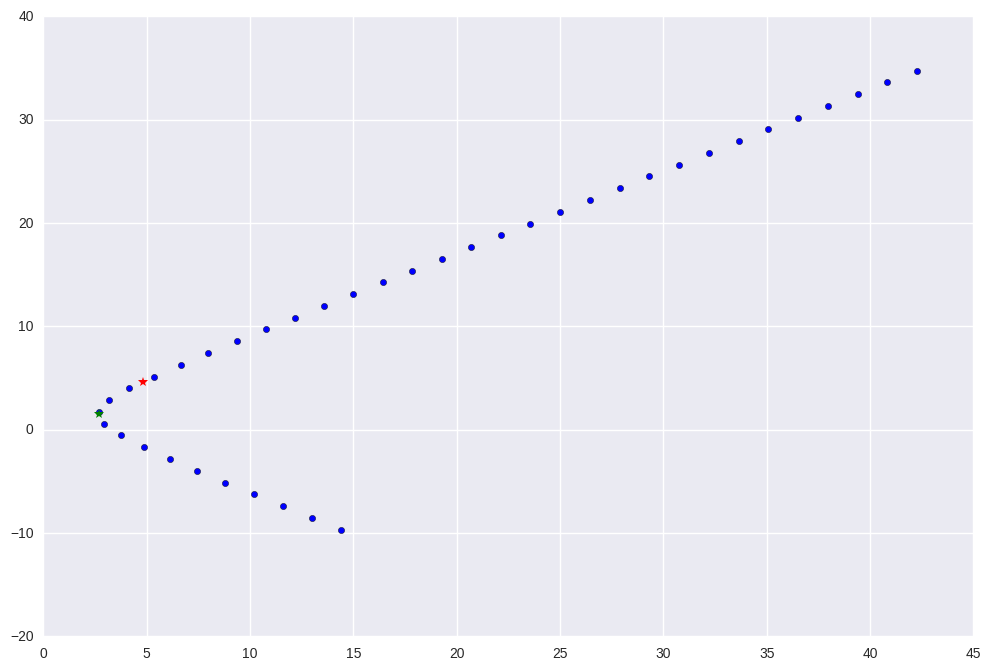

In [29]:
plt.figure(figsize=(12, 8))
plt.scatter(res['std_deviation']*np.sqrt(12.)*100, res['expected_returns']*12.*100);
plt.plot(sd_ORP*np.sqrt(12.)*100, rtn_ORP*12.*100, 'r*');
plt.plot(sd_MVP*np.sqrt(12.)*100, rtn_MVP*12.*100, 'g*');

*****

# Summary Table
The section provides the solution for all groups' portfolio expected returns, standard deviation, MVP and ORP.

In [30]:
def locator(r_s, r_b, sd_s, sd_b, corr_sb, rf):
    # This function locates the MVP and ORP weight for bond
    mvp_b = (sd_s**2 - sd_b * sd_s * corr_sb) / (sd_s**2 + sd_b**2 - 2*sd_b*sd_s*corr_sb)
    
    orp_b = ((r_b-rf)*sd_s**2 - (r_s-rf)*sd_b*sd_s*corr_sb) / \
            ((r_b-rf)*sd_s**2 + (r_s-rf)*sd_b**2 - (r_b-rf+r_s-rf)*sd_b*sd_s*corr_sb)    
    return mvp_b, orp_b

In [31]:
def rtn_std(r_s, r_b, sd_s, sd_b, corr_sb, rf, wb, asset_1, asset_2):
    rtn = (1-wb) * r_s + wb * r_b
    std = np.sqrt((wb * sd_b) ** 2 + ((1-wb) * sd_s) ** 2 + 2 * (wb * sd_b) * ((1-wb) * sd_s) * \
                                       corr_mat[asset_1][asset_2])
    return rtn, std

In [32]:
k = 1

In [33]:
n = np.arange(1,12,2)

In [34]:
dat = []
for k in n:
    mvp = locator(summary_stats['Average'][k], summary_stats['Average'][k+1], 
                  summary_stats['Standard_Deviation'][k], summary_stats['Standard_Deviation'][k+1], 
                  corr_mat.iloc[k,k+1], summary_stats['Average']['Tbill'])[0]
    orp = locator(summary_stats['Average'][k], summary_stats['Average'][k+1], 
                  summary_stats['Standard_Deviation'][k], summary_stats['Standard_Deviation'][k+1], 
                  corr_mat.iloc[k,k+1], summary_stats['Average']['Tbill'])[1] 
    dat.append([summary_stats.index[k], 
                summary_stats.index[k+1],
                summary_stats['Average'][k], 
                summary_stats['Average'][k+1],
                summary_stats['Standard_Deviation'][k], 
                summary_stats['Standard_Deviation'][k+1],
                corr_mat.iloc[k,k+1], 
                summary_stats['Average']['Tbill'],
                mvp, 
                orp,
                rtn_std(summary_stats['Average'][k], summary_stats['Average'][k+1], 
                        summary_stats['Standard_Deviation'][k], summary_stats['Standard_Deviation'][k+1], 
                        corr_mat.iloc[k,k+1], summary_stats['Average']['Tbill'], mvp, 
                        summary_stats.index[k], summary_stats.index[k+1])[0],
                rtn_std(summary_stats['Average'][k], summary_stats['Average'][k+1], 
                        summary_stats['Standard_Deviation'][k], summary_stats['Standard_Deviation'][k+1], 
                        corr_mat.iloc[k,k+1], summary_stats['Average']['Tbill'], mvp, 
                        summary_stats.index[k], summary_stats.index[k+1])[1],
                rtn_std(summary_stats['Average'][k], summary_stats['Average'][k+1], 
                        summary_stats['Standard_Deviation'][k], summary_stats['Standard_Deviation'][k+1], 
                        corr_mat.iloc[k,k+1], summary_stats['Average']['Tbill'], orp, 
                        summary_stats.index[k], summary_stats.index[k+1])[0],
                rtn_std(summary_stats['Average'][k], summary_stats['Average'][k+1], 
                        summary_stats['Standard_Deviation'][k], summary_stats['Standard_Deviation'][k+1], 
                        corr_mat.iloc[k,k+1], summary_stats['Average']['Tbill'], orp, 
                        summary_stats.index[k], summary_stats.index[k+1])[1]                
               ])

In [35]:
pd.DataFrame(dat, columns=['Asset_1', 'Asset_2', 'r_1', 'r_2', 
                         'sd_1', 'sd_2', 'corr_12', 'T-bill',
                         'mvp_b', 'orp_b', 'mvp_rtn', 'mvp_sd', 'orp_rtn', 'orp_sd'])

,Asset_1,Asset_2,r_1,r_2,sd_1,sd_2,corr_12,T-bill,mvp_b,orp_b,mvp_rtn,mvp_sd,orp_rtn,orp_sd
0,XLU,VTI,0.0060,0.0100,0.0341,0.0392,0.3199,0.0001,0.3982,0.6493,0.0076,0.0295,0.0086,0.0314
1,AGG,QQQ,0.0005,0.0146,0.0084,0.0439,-0.1241,0.0001,0.0561,0.4158,0.0013,0.0080,0.0063,0.0183
2,BND,XLP,0.0002,0.0098,0.0087,0.0310,0.0577,0.0001,0.0596,0.9671,0.0008,0.0085,0.0094,0.0300
3,BSV,EEM,-0.0001,-0.0008,0.0041,0.0572,0.0715,0.0001,0.0001,0.0195,-0.0001,0.0041,-0.0001,0.0043
4,BIV,EFA,0.0005,0.0027,0.0134,0.0485,-0.0463,0.0001,0.0807,0.3090,0.0007,0.0127,0.0012,0.0172
5,VNQ,EWJ,0.0101,0.0039,0.0479,0.0433,0.4152,0.0001,0.5842,0.0057,0.0065,0.0382,0.0101,0.0477


# The End